# <span style='font-family:Helvetica;font-size:20pt;color:DarkCyan;font-weight:bold'>Vanilla Generative Adversarial Networks for non Computer Scientists:</span>
---

Generative Adversarial Networks or GANs, are a type of generative model crafted by [Ian Goodfellow](https://www.linkedin.com/in/ian-goodfellow-b7187213/) and presented in the paper ["Generative Adversarial Network" (2014)](https://arxiv.org/abs/1406.2661). This is a particular type of unsupervised learning, in which two neural networks compete with each others. The first network, called __DISCRIMINATOR (D)__, has to discriminate between fake and real input. The second network, the __GENERATOR (G)__, has to generate sample that resemble the most possible real data. 

But, what is the difference between a discriminative and a generative model?? 

## Discriminative and Generative Models

Let's say we want to build a model that is able to correctly classify T-Rex and bee. A discriminative model (right) will produce a decision boundary that divides the two classes without learning how the data has been generated. Mathematically, a discriminative model learns the conditional probability of the label $Y$ given the data $X$:

$$ \text{discriminative} : P(Y | X) $$

A generative model (left) instead, will learn the joint probability of the data and the label, from which it can compute the conditional probability of the data $X$, given the label $Y$:

$$ \text{generative} : P(X, Y) \rightarrow P(X) = P(X | Y) P(Y) $$

<img src="../images/generative_discriminative.png" width=600 height=600 />

## Generative Adversarial Networks
As we said above, GANs are composed by two networks:

__GENERATOR__: the generator learns to produce samples $\textbf x = g(z; \boldsymbol{\theta} ^g)$, where $\boldsymbol{\theta} ^g$ represents the weights of the generator network and $z$ represent random noise.

__DISCRIMINATOR__: the discriminator will discriminate if the given input is real or fake, based on the function $d(\textbf x; \boldsymbol{\theta} ^d)$. Basically, it performs binary classification.

So, __G__ tries to capture the data distribution, and __D__ to estimates the probability that a sample comes from the training data.

How are GANs trained? First of all, it is important to understand that since we are working with two distinct network, we will have to train them in two separate ways (this is not general, but here it applies). Since outputs can be $0$ (fake) or $1$ (real) a natural choice for the loss is the __binary cross-entropy__. Given a data set composed by $M$ samples, the loss can be computed as:

$$ \mathcal J = - \sum_i^M [y_i \log(D(\textbf x_i)) + (1 - y_i) \log(1 - D(G(\textbf x_i)))] $$

where $D(\textbf x_i)$ is the output of the discriminator. If you find hard to understand this loss function please read the chapter 4.3.2 of the book [PRML](https://www.amazon.it/Pattern-Recognition-Machine-Learning-Christopher/dp/0387310738). We can see that depending on the value of $y_i$ (that we know) one of the two terms disappears: if $y_i = 0$ disappears the first right hand side (RHS) term, while if $y_i = 1$ disappears the second RHS term.

1. Item $y_i = 0$:
    * if $D(\textbf x_i) \approx 0$ then the loss will be close to zero.
    * if $D(\textbf x_i) \approx 1$ then the loss will tends to $- \infty$

2. Item $y_i = 1$:
    * if $D(\textbf x_i) \approx 1$ then the loss will be close to zero.
    * if $D(\textbf x_i) \approx 0$ then the loss will tends to $- \infty$
    
The objective of the Discriminator is to minimize this term: minimizing it, means reducing the possibility to wrongly classify samples. This is the standard loss used to train D.

For what concern the Generator, basically, its objective is to fool D making it classy fake images are real. So, easy, we can use as loss for the Generator the same equation but we will try to maximize it. This choice of loss function produces what is called a __minimax__ game since D tries to minimize it while G tries to maximize it (if you are reading the original paper the formulation of the loss is expressed with an opposite sign so the goals of D and G are the opposite). The problem with this formulation is that the optimization problem is not easy, GANs are prone to underfit and it is not guarantee to reach an equilibrium. Another problem related to the minimax formulation is that when G is weak and D is strong (correctly classify almost all the samples), the loss no longer gives good gradients for training G.

An alternative formulation is the one in which G tries to increase the log probability that D makes a mistake, rather than aiming to decrease the log-probability that D makes the correct prediction. By noticing that during the training process of G, the first RHS term is useless since it does not depend on G, we can write the loss function for the generator as:

$$ \mathcal J^g = - \sum_i^M  \log(D(G(\textbf x_i))) $$

Now that we understand which losses we will use, let's dive into the workflow of GANs training that we will implement in this notebook. We can identify $9$ main points:


<img src="../images/vanilla-gans.png" width=800 height=800 />

Before training:
1. Download the MNIST data set $(1)$;
2. Create batches from the data set $(2)$;

During training for D:
3. Pick the current real batch $(3)$;
4. Generate random noise from the latent space $(4)$;
5. Pass random noise to G to generate a fake batch $(5)$;
6. Pass real and fake batches through D $(6)$;
7. Compute loss for D $(7)$;
8. Backpropagate to D $(8)$;

During training for G:
9. Generate random noise from the latent space $(4)$;
10. Pass random noise to G to generate a fake batch $(5)$;
11. Pass just the fake batch through D $(6)$;
12. Compute loss for G $(7)$;
13. Backpropagate to G $(9)$

Amazing, now that we understood how GANs work we can move from the theoretical part to coding!!!

### Code

Ok, we can start by importing the required libraries. As the name of the notebook suggests, we will make use of the PyTorch library. You can find usefull to look at the official [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [1]:
import os
import time
import enum

import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader

Since I currently have a low-power MacBook Pro, I can't run the project on my personal pc, so I have to rely on Colab. In order to easily save and upload stuff I need to mount my Google Drive on the runtime. To do so, run the following cell, go to the link produced and enter the authorization code.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In Colab we can use for free a GPU. To do so click on _Runtime_ $\rightarrow$ _Change runtime type_ $\rightarrow$ _Hardware accelerator_ $\rightarrow$ _GPU_

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  cuda = True
else:
  device = torch.device("cpu")
  cuda = False
print(f'Working with GPU: {cuda}')

Working with GPU: True


We can now define some useful path that we will use in order to make the project more orderly.

In [4]:
DRIVE_MAIN_DIR_PATH = os.path.join(os.getcwd(), 'drive/My Drive/Colab Notebooks/GANs')
DATA_DIR_PATH = os.path.join(DRIVE_MAIN_DIR_PATH, 'data')
IMG_DIR_PATH = os.path.join(DRIVE_MAIN_DIR_PATH, 'images/models/gan')

### Model

At this point we are ready to implement our GANs!!! 

Let's start defining the __Generator__:

In [5]:
class Generator(nn.Module):
    """  Generator class: a class to instantiate the generator network and to
    implement its forward pass.

    Args:
        latent_dim (int): dimension of the latent vector;
        image_dim (tuple): tuple containing number of pixel of the image
        along width and height;
        hidden_dim (int): number of neurons in first hidden layer
    """
    def __init__(self, latent_dim=100, image_dim=(28, 28), hidden_dim = 128):
        super(Generator, self).__init__()
        self.image_dim = image_dim
        def generator_block(in_dim, out_dim):
            """ Function to generate a block of layers for the generator
            network: Linear + BN + LeakyReLU.

            Args:
                in_dim (int): length of input vector;
                out_dim (int): length of output vector

            Returns:
                layers (list): a list containing a block of layers
            """
            layers = [nn.Linear(in_features=in_dim, out_features=out_dim)]
            layers.append(nn.BatchNorm1d(num_features=out_dim))
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            return layers

        # Define the architecture
        self.model = nn.Sequential(
            # Unpacking lists of layers
            *generator_block(latent_dim, hidden_dim),
            *generator_block(hidden_dim, hidden_dim * 2),
            *generator_block(hidden_dim * 2, hidden_dim * 4),
            *generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, int(np.prod(image_dim))),
            nn.Sigmoid()
        )

    def forward(self, z):
        """ Forward pass for the generator network.

        Args:
            z (Tensor): a noise tensor with dimensions 
            (n_samples, latent_dim)

        Returns:
            fake_image (Tensor): a fake image with dimension 
            (n_samles, (image_dim)). In this case image_dim = (28, 28)
        """
        fake_image = self.model(z)
        # Reshape the vector into image shape
        fake_image = fake_image.view(fake_image.size(0), 1, *self.image_dim)
        return fake_image

In order to start generating images with the Generator, we need to feed it with random noise. Let's define a function to generate this noise!

In [6]:
def generate_noise(num_samples, latent_dim):
    """ Noise generator for the input of the generator network.

    Args:
        num_sample (int): number of samples in the current batch;
        latent_dim (int): dimension of the latent space
    Returns:
        z (Tensor): a Tensor containing noise vector for each sample
    """
    z = torch.randn((num_samples, latent_dim)).to(device)
    return z

In [7]:
# Print Generator summary
generator = Generator(latent_dim=100, image_dim=(28, 28), hidden_dim = 128).to(device)
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=1024, out_features=784, bias=True)
    (13): Sigmoid()
  )
)


In [8]:
# Check the noise tensor
generate_noise(10, 100).shape

torch.Size([10, 100])

In [9]:
# Check the generator output
generator(generate_noise(10, 100)).shape

torch.Size([10, 1, 28, 28])

Now we define the __Discriminator__:

In [10]:
class Discriminator(nn.Module):
    """  Discriminator class: a class to instantiate the discriminator network 
    and to implement its forward pass.

    Args:
        latent_dim (int): dimension of the latent vector;
        image_dim (tuple): tuple containing number of pixel of the image
        along width and height;
        hidden_dim (int): number of neurons in first hidden layer
    """
    def __init__(self, image_dim=(28, 28), hidden_dim = 128):
        super(Discriminator, self).__init__()

        def discriminator_block(in_dim, out_dim):
            """ Function to generate a block of layers for the discriminator
            network: Linear + LeakyReLU.

            Args:
                in_dim (int): length of input vector;
                out_dim (int): length of output vector

            Returns:
                layers (list): a list containing a block of layers
            """
            layers = [nn.Linear(in_features=in_dim, out_features=out_dim)]
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            return layers

        # Define the architecture
        self.model = nn.Sequential(
            # Unpacking lists of layers
            *discriminator_block(int(np.prod(image_dim)), hidden_dim * 4),
            *discriminator_block(hidden_dim * 4, hidden_dim * 2),
            *discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        """ Forward pass for the discriminator network.

        Args:
            image (Tensor): an image tensor

        Returns:
            prediction (Tensor): a vector of 1s and 0s
        """
        # Reshape image into a vector
        image = image.view(image.size(0), -1)
        prediction = self.model(image)
        
        return prediction

In [11]:
# Print Generator summary
discriminator = Discriminator(image_dim=(28, 28), hidden_dim = 128).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [12]:
# Check Discriminator output
discriminator(generator(generate_noise(10, 100))).shape

torch.Size([10, 1])

### MNIST data set

In this notebook we will play around with the [MNIST](http://yann.lecun.com/exdb/mnist/) data set. This data set contains $60000$ training images and $10000$ testing imagis of hand-written digits, from $0$ to $9$. Every image will be composed by $28\times28$ pixels. We can download the data set into the corresponding _data_ folder.

Now can be usefull to familiarize with the MNIST data set by looking at what it contains.

In [13]:
# We need to define here the batch size
batch_size = 128

# With the Class DataLoader we can combine a data set and a sampler. 
mnist_dataloader = DataLoader(
    MNIST(
        root=DATA_DIR_PATH, download=True, train=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, drop_last=False)

In [14]:
print(f'Number of batches: {len(mnist_dataloader)}')
print(f'Number of elements in mnist_dataloader : {len(next(iter(mnist_dataloader)))}')
print(f'Data set data loader: {next(iter(mnist_dataloader))[0].shape}')

Number of batches: 469
Number of elements in mnist_dataloader : 2
Data set data loader: torch.Size([128, 1, 28, 28])


Since we set the flag `drop_last` as `False`, the last batch can be of different size. This is due to the fact the $60000/128$ is not an entire number.
The number of elements of the dataloader are $2$ because in position $[0]$ we have the training set, and in position $[1]$ we have training labels. Please notice that through the `next` function we select the first batch. From the third output we can see that the current batch is composed by $128$ images of $28 \times 28$ pixels. The number $1$ in `torch.Size()` is relative to the number of channels of the image, in this case we have just grayscale images.

To better understand the data set we can plot some sample. To do so we first define an utility function.

In [39]:
def show_images(image_tensor, num_images=25):
    """Function for visualizing images from torch Tensor

        Args:
            image_tensor (Tensor): an image tensor;
            num_images (int): number of images to display;
    """
    # Detach from gradient and move from GPU to CPU
    image_cpu = image_tensor.detach().cpu()
    image_grid = make_grid(image_cpu[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

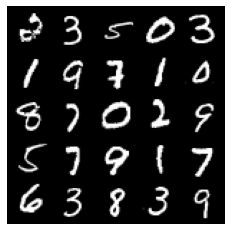

In [41]:
# Pick batch
curr_batch = next(iter(mnist_dataloader))
# Batch of inputs
X_batch = curr_batch[0]
# Batch of outputs
Y_batch = curr_batch[1]

show_images(X_batch)

In [ ]:
"""
# Number of samples to display per row
mnist_samples = 4

# Plot
fig = plt.figure(figsize=(9, 5))
rect = Rectangle((0.06, 0.05), 0.88, 1, facecolor='gray', edgecolor='none',
                 transform=fig.transFigure, zorder=-1)
fig.patches.append(rect)
fig.suptitle("MNIST samples", fontsize=15)
grid = gridspec.GridSpec(2, mnist_samples, 
                         top=0.9, bottom=0.1, left=0.1, right=0.9,
                         wspace=0.05, hspace=0.05)
for i in range(mnist_samples):
    # First row
    ax = plt.subplot(grid[0, i])
    ax.imshow(-X_batch[i].squeeze(), cmap='binary')
    ax.set_title('Label ' + str(Y_batch[i].numpy()), fontsize = 13)
    plt.axis('off')
    # Second row
    ax = plt.subplot(grid[1, i])
    ax.imshow(-X_batch[i+mnist_samples].squeeze(), cmap='binary')
    ax.set_title('Label ' + str(Y_batch[i+mnist_samples].numpy()), fontsize = 13)
    ax.patch.set_edgecolor('c')  
    plt.axis('off')

And now? It's __training time__!!!

### Training

We have to specify the hyperparameters of our model.

In [42]:
# Loss function
adversarial_loss = nn.BCELoss()

# Number of epochs to train the model
epochs = 100

# Number of optimization step after which display and save images 
display_step = 500

# Dimension of the noise vector
latent_dim = 100

# Learning rate
lr = 0.0002

We first instantiate the Generator and the Discriminator objects:

In [43]:
generator = Generator(latent_dim=100, image_dim=(28, 28), hidden_dim = 128).to(device)
discriminator = Discriminator(image_dim=(28, 28), hidden_dim = 128).to(device)

Now we define the optimizers for both generator and discriminator. We will use the very popular Adam optimizer with standard hyperparameters.

In [44]:
generator_opt = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

The training procedure for GANs is a little bit different than for the other networks architecture. We have to define separately how to compute the loss for the two competing networks, as we saw earlier.

In [45]:
def get_discriminator_loss(generator, discriminator, adversarial_loss, real,
                           num_images, latent_dim):
    """ Compute Discriminator loss.

    Args:
        generator: generator network;
        discriminator: discriminator network;
        adversarial_loss: binary cross entropy loss;
        real (Tensor): real images;
        num_images (int): number of fake images to generate;
        latent_dim (int): dimension of the latent space
    Returns:
        discriminator_loss: loss of the discriminator network
    """
    # Generate noise from latent space
    random_input = generate_noise(num_images, latent_dim)
    # Generate images
    generated_images = generator(random_input)
    # Discriminator prediction on fake images. We use detach since 
    # here we are computing the loss of the Discriminator
    pred_D_fake = discriminator(generated_images.detach())
    # Loss on fake images
    fake_loss = adversarial_loss(pred_D_fake, torch.zeros_like(pred_D_fake))
    # Discriminator prediction on real images.
    pred_D_real = discriminator(real)
    # Loss on real images
    real_loss = adversarial_loss(pred_D_real, torch.ones_like(pred_D_real))
    discriminator_loss = 0.5 * (fake_loss + real_loss)
    return discriminator_loss

In [46]:
def get_generator_loss(generator, discriminator, adversarial_loss, 
                       num_images, latent_dim):
    """ Compute Generator loss.

    Args:
        generator: generator network;
        discriminator: discriminator network;
        adversarial_loss: binary cross entropy loss;
        num_images (int): number of fake images to generate;
        latent_dim (int): dimension of the latent space
    Returns:
        generator_loss: loss of the generator network
    """
    # Generate noise from latent space
    random_input = generate_noise(num_images, latent_dim)
    # Generate images
    generated_images = generator(random_input)
    # Discriminator prediction on fake images
    pred_D_fake = discriminator(generated_images)
    # Generator loss
    generator_loss = adversarial_loss(pred_D_fake, torch.ones_like(pred_D_fake))
    return generator_loss

Let's see some of the samples that our untrained Generator produces:

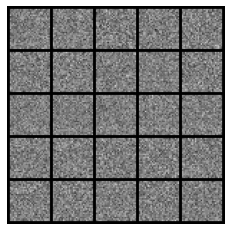

In [47]:
sampling_noise = generate_noise(25, latent_dim)
sampling_fake = generator(sampling_noise)
show_images(sampling_fake)
save_image(sampling_fake.data[:25], IMG_DIR_PATH + '/0.png', nrow=5)

We can now move on the cool part. Let's train our model and see how the generator learns to produce images that look very similar to the MNIST samples.

In [ ]:
curr_step = 0
for epoch in range(epochs):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for curr_batch, _ in tqdm(mnist_dataloader):
        curr_batch_len = len(curr_batch)

        real = curr_batch.to(device)

        # Put to zero the gradients before backpropagation
        discriminator_opt.zero_grad()
        # Calculate discriminator loss
        discriminator_loss = get_discriminator_loss(generator, discriminator,
                                                    adversarial_loss, real,
                                                    curr_batch_len, latent_dim)
        # Update gradients
        discriminator_loss.backward(retain_graph=True)
        # Update optimizer
        discriminator_opt.step()

        # Put to zero the gradients before backpropagation
        generator_opt.zero_grad()
        # Calculate discriminator loss
        generator_loss = get_generator_loss(generator, discriminator,
                                            adversarial_loss, curr_batch_len,
                                            latent_dim)
        # Update gradients
        generator_loss.backward(retain_graph=True)
        # Update optimizer
        generator_opt.step()

        mean_generator_loss += generator_loss.item() / len(mnist_dataloader)
        mean_discriminator_loss += discriminator_loss.item() / len(mnist_dataloader)

        # Save The image every display_epoch epochs
        if curr_step % display_step == 0 and curr_step > 0:
            print(f"Epoch {epoch}/{epochs}, Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
            sampling_noise = generate_noise(curr_batch_len, latent_dim)
            sampling_fake = generator(sampling_noise)
            show_images(sampling_fake)
            save_image(sampling_fake.data[:25], IMG_DIR_PATH + '/%d.png' % curr_step, nrow=5)

        curr_step += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Generate a gif
images = []
num = 0
while num < 46500:
    file_name = 'gan' + str(num) + '.png'
    file_path = os.path.join(IMG_DIR_PATH, file_name)
    images.append(imageio.imread(file_path))
    num += 500
imageio.mimsave(IMG_DIR_PATH + '/gan_gif.gif', images, duration=0.1)

Now that we finish to train our GANs, we can sample from the latent space, send this noise to the generator and produce images that look very similar to those inside the MNIST data set.

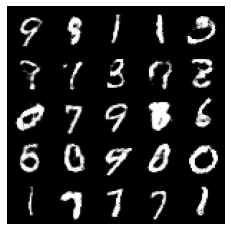

In [ ]:
sampling_noise = generate_noise(25, latent_dim)
sampling_fake = generator(sampling_noise)
show_images(sampling_fake)
save_image(sampling_fake.data[:25], IMG_DIR_PATH + '0.png', nrow=5)

<span style='font-family:Helvetica;font-size:20pt;color:DarkCyan;font-weight:bold'>References:</span>
1. [Build Basic Generative Adversarial Network (Coursera)](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans)
2. [Understanding Generative Adversarial Networks](https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/![image.png](attachment:image.png))
2. [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160)
3. [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
4. https://github.com/gordicaleksa/pytorch-gans
5. https://github.com/eriklindernoren/PyTorch-GAN
6. https://www.youtube.com/watch?v=yz6dNf7X7SA&t=17s